In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import numpy.random as rnd

In [3]:
import matplotlib.pyplot as pl
%matplotlib inline

In [4]:
floatX = np.float32

In [5]:
sess = tf.InteractiveSession()

In [6]:
import os

# Model organization 01

In [7]:
class AffineModel:
    def __init__(self, name):
        self.name = name
        with tf.variable_scope(name):
            self.a = tf.get_variable(name = "a", dtype = floatX, initializer = 1.0)
            self.b = tf.get_variable(name = "b", dtype = floatX, initializer = 0.0)

    def predict(self, x, name):
        a, b = self.a, self.b
        with tf.variable_scope(name):
            x = tf.identity(x, name= "x")
            linear_part = tf.multiply(a, x, "linear_part")
            y = tf.identity(linear_part + b, "y")
            return y
        
    def plot_calculation(self, y, feed_dict = None):
        scope = os.path.split(y.name)[0]
        graph = y.graph
        x = graph.get_tensor_by_name(scope + "/x:0")
        xxx, yyy = sess.run([x, y], feed_dict)
        
        pl.scatter(xxx, yyy)

        

In [8]:
model = AffineModel("affine_model_01")

In [9]:
xx = tf.Variable(
    initial_value = tf.random_normal([10]), 
    validate_shape = False, 
    dtype = floatX, 
    name = "xx"
)
xx.set_shape([None])

In [10]:
yy = model.predict(x = xx, name = "prediction")

In [11]:
sess.run(tf.global_variables_initializer())

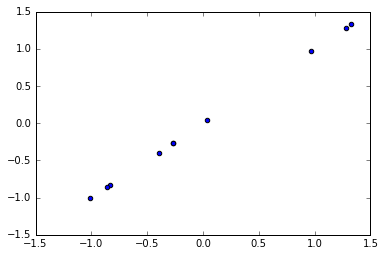

In [12]:
model.plot_calculation(yy)

# Model organization 02

In [13]:
import types

In [14]:
class AffineModel_02:
    instance_counter = 0
    
    def __init__(self, name = None):
        self.__class__.instance_counter += 1
        self.piname = "{}_instance{}".format(
                self.__class__.__name__,
                self.__class__.instance_counter,
            )               
        if name is None:
            name = self.piname
            
        self.call_counter = 0
            
        with tf.variable_scope(name) as scope:
            self.name = scope.name
            self.a = tf.get_variable(name = "a", dtype = floatX, initializer = 1.0)
            self.b = tf.get_variable(name = "b", dtype = floatX, initializer = 0.0)
            

    def __call__(self, x, name = None):
        self.call_counter += 1
        if name is None:
            name = "{}_call{}".format(
                self.piname,
                self.call_counter
            )
        a, b = self.a, self.b
        with tf.variable_scope(name) as scope:
            x = tf.identity(x, name= "x")
            linear_part = tf.multiply(a, x, "linear_part")
            y = tf.identity(linear_part + b, "y")
            
            y.piplot = lambda feed_dict = None: self.plot_calculation(x, y, feed_dict)
            
            return y
        
    def plot_calculation(box, x, y, feed_dict = None):
        xxx, yyy = sess.run([x, y], feed_dict)
        
        pl.scatter(xxx, yyy)

        

In [15]:
model = AffineModel_02()

In [16]:
xx = tf.Variable(
    initial_value = tf.random_normal([10]), 
    validate_shape = False, 
    dtype = floatX, 
    name = "xx"
)
xx.set_shape([None])

In [17]:
yy = model(xx)

In [18]:
sess.run(tf.global_variables_initializer())

In [19]:
yy.eval()

array([ 0.42999256,  0.8627096 ,  1.6801155 , -0.78902525, -0.4804639 ,
        0.7099708 , -1.2336301 ,  0.8843545 , -1.4424317 ,  1.9586202 ],
      dtype=float32)

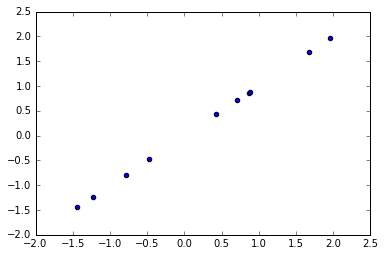

In [20]:
yy.piplot()

### Tensorboard

In [21]:
tb_dir = r"D:\python_source\data\bordel\tesorboard_test_01"
tb_dir 

'D:\\python_source\\data\\bordel\\tesorboard_test_01'

In [22]:
tb_writer = tf.summary.FileWriter(tb_dir)
tb_writer.add_graph(tf.get_default_graph())

# Bordel

In [10]:
graph = tf.get_default_graph()

In [11]:
with tf.variable_scope("aa"):
    with tf.variable_scope("bb"):
        print(graph.get_name_scope())
        print(tf.Variable(initial_value=1.0, name = "vv"))
        print(tf.get_variable(name = "uu", initializer=1.0))
        

aa/bb
<tf.Variable 'aa/bb/vv:0' shape=() dtype=float32_ref>
<tf.Variable 'aa/bb/uu:0' shape=() dtype=float32_ref>


In [54]:
with tf.variable_scope("aa", reuse = True, auxiliary_name_scope=False) as scope1:
    with tf.variable_scope("bb", reuse = True, auxiliary_name_scope=False) as scope:

        print(graph.get_name_scope())
        print(scope.name)
        
        uu = tf.get_variable(name = "uu")
        print(uu)
        print(tf.identity(uu*2, "uu_squared"))


None
aa/bb
<tf.Variable 'aa/bb/uu:0' shape=() dtype=float32_ref>
Tensor("uu_squared:0", shape=(), dtype=float32)


In [61]:
with tf.variable_scope("aa/bb", reuse = True, auxiliary_name_scope=False) as scope1:
        print(graph.get_name_scope())
        print(scope.name)
        
        uu = tf.get_variable(name = "uu")
        print(uu)
        print(tf.identity(uu*2, "uu_squared"))


None
aa
<tf.Variable 'aa/bb/uu:0' shape=() dtype=float32_ref>
Tensor("uu_squared_1:0", shape=(), dtype=float32)


In [55]:
str(scope)

'<tensorflow.python.ops.variable_scope.VariableScope object at 0x0000023DF8202F98>'

In [47]:
with tf.variable_scope("aa", reuse = True, auxiliary_name_scope=False):
    print(graph.get_name_scope())
        
    with tf.variable_scope("bb", reuse = True):
        print(graph.get_name_scope())
        uu = tf.get_variable(name = "uu", initializer=1.0)
        print(uu)
        print(tf.identity(uu*2, "uu_squared"))

aa_20/bb
<tf.Variable 'aa/bb/uu:0' shape=() dtype=float32_ref>
Tensor("aa_20/bb/uu_squared:0", shape=(), dtype=float32)


In [12]:
with tf.name_scope("aa"):
    with tf.name_scope("bb"):
        print(graph.get_name_scope())
        print(tf.Variable(initial_value=1.0, name = "vv"))
        print(tf.get_variable(name = "uu", initializer=1.0))

aa_1/bb
<tf.Variable 'aa_1/bb/vv:0' shape=() dtype=float32_ref>
<tf.Variable 'uu:0' shape=() dtype=float32_ref>


In [13]:
with tf.name_scope("aa") as aa_scope:
    with tf.name_scope("bb"):
        print(graph.get_name_scope())
        print(tf.Variable(initial_value=1.0, name = "vv"))

aa_2/bb
<tf.Variable 'aa_2/bb/vv:0' shape=() dtype=float32_ref>


In [37]:
with tf.variable_scope("aa", auxiliary_name_scope=True) as scope:
    print(graph.get_name_scope(), scope)
        

aa_15 <tensorflow.python.ops.variable_scope.VariableScope object at 0x0000023DF820B8D0>


In [37]:
with tf.variable_scope("aa", auxiliary_name_scope=True) as scope:
    print(graph.get_name_scope(), scope)
        

aa_15 <tensorflow.python.ops.variable_scope.VariableScope object at 0x0000023DF820B8D0>


In [38]:
aa_scope = tf.name_scope("aa")
aa_scope

In [39]:
aa_scope.name

'aa'

In [40]:
tf.name_scope("aa", ) == aa_scope

False

In [22]:
with tf.variable_scope("aa", reuse = True) as scope:
    graph = tf.get_default_graph()
    print(graph.get_name_scope())
    print(scope.name)

aa_2
aa


In [23]:
with tf.variable_scope("aa") as scope:
    graph = tf.get_default_graph()
    print(graph.get_name_scope())
    print(scope.name)

aa_3
aa


In [24]:
with tf.variable_scope("aa", auxiliary_name_scope=False) as scope:
    graph = tf.get_default_graph()
    print(graph.get_name_scope())
    print(scope.name)

None
aa
